In this example, heat transport is due to both advection and diffusion. Also, we've enforced incompressiblity, so the velocity field is divergence-free.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import imageio
from imageio import imread
from PIL import Image
import matplotlib.pyplot as plt
import os

In [2]:
n_grid = 110
dx = 1.0 / n_grid
steps = 100
dt = 1.0/ steps
learning_rate = 100
diffusivity = 0.001
n_gauss_seidel = 5

In [3]:
def advect(field, velocity, t_offset, t):
    """Semi-Lagrangian advection: Backtrace from (x, y) using velocity."""
    X, Y = jnp.meshgrid(jnp.arange(n_grid), jnp.arange(n_grid), indexing='ij')

    # compute the backtraced position where a paricle at (X, Y) was at previous time step
    center_x = X - velocity[t + t_offset, ..., 0] * dt
    center_y = Y - velocity[t + t_offset, ..., 1] * dt

    # wrap backtraced position around domain boundary (periodic boundary conditions)
    fx = jnp.mod(center_x, n_grid)
    fy = jnp.mod(center_y, n_grid)

    # split the backtraced position into integer and fractional parts
    ix = jnp.floor(fx).astype(int)
    iy = jnp.floor(fy).astype(int)
    dx = fx - ix
    dy = fy - iy

    # compute indices of the four surrounding grid points
    ix0 = ix % n_grid
    iy0 = iy % n_grid
    ix1 = (ix + 1) % n_grid
    iy1 = (iy + 1) % n_grid

    # samples the field at the four surrounding grid points at previous time step
    T00 = field[t - 1, ix0, iy0]
    T10 = field[t - 1, ix1, iy0]
    T01 = field[t - 1, ix0, iy1]
    T11 = field[t - 1, ix1, iy1]

    # bilinear interpolation, weighted by the fractional parts
    interpolated = (1 - dx) * (1 - dy) * T00 + dx * (1 - dy) * T10 + \
                   (1 - dx) * dy * T01 + dx * dy * T11
    return interpolated



In [4]:
def diffuse(T):
    laplacian = (jnp.roll(T, 1, axis=0) + jnp.roll(T, -1, axis=0) +
                 jnp.roll(T, 1, axis=1) + jnp.roll(T, -1, axis=1) -
                 4 * T) / (dx**2)
    return T + diffusivity * laplacian * dt

In [5]:
def divergence(v):
    dvx_dx = (jnp.roll(v[..., 1], -1, axis=1) - jnp.roll(v[..., 1], 1, axis=1)) / (2 * dx)
    dvy_dy = (jnp.roll(v[..., 0], -1, axis=0) - jnp.roll(v[..., 0], 1, axis=0)) / (2 * dx)
    return dvx_dx + dvy_dy

In [6]:
def compute_pressure(div):
    p = jnp.zeros_like(div)
    for i in range(n_gauss_seidel):  
        p = 0.25 * (jnp.roll(p, 1, axis=0) + jnp.roll(p, -1, axis=0) +
                    jnp.roll(p, 1, axis=1) + jnp.roll(p, -1, axis=1) - dx**2 * div)
    return p

In [7]:
def update_velocity(v):
    div_v = divergence(v)
    p = compute_pressure(div_v)
    grad_p_x = (jnp.roll(p, -1, axis=0) - jnp.roll(p, 1, axis=0)) / (2 * dx)
    grad_p_y = (jnp.roll(p, -1, axis=1) - jnp.roll(p, 1, axis=1)) / (2 * dx)
    v_updated = jnp.stack([
        v[..., 0] - grad_p_x,
        v[..., 1] - grad_p_y
    ], axis=-1)

    return v_updated


In [14]:
def forward(v0, T0, T_target):
    v = jnp.broadcast_to(v0, (steps, n_grid, n_grid, 2)) # broadcast v0 to all time steps
    T = jnp.zeros((steps, n_grid, n_grid)).at[0].set(T0)

    for t in range(1, steps):
        v = v.at[t - 1].set(update_velocity(v[t - 1]))
        T_adv = advect(T, v, -1, t)
        T = T.at[t].set(diffuse(T_adv))

    loss = jnp.mean((T[-1] - T_target) ** 2)
    return loss, T

In [15]:
def optimize(v0, T0, T_target, num_iters=100):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(v0)

    @jax.jit
    def step(v, opt_state):
        loss_and_grad_fn = jax.value_and_grad(lambda v: forward(v, T0, T_target)[0])
        loss, grads = loss_and_grad_fn(v) 
        updates, opt_state = optimizer.update(grads, opt_state)
        v = optax.apply_updates(v, updates)
        return v, opt_state, loss

    for i in range(num_iters):
        v0, opt_state, loss = step(v0, opt_state)
        if i % 10 == 0:
            print(f"Iter {i}, Loss: {loss:.6f}")
    return v0

In [16]:
def load_images():
    T0 = imread("./images/initial.png")[:, :, 0] / 255.0
    T_target = imread("./images/final.png")[:, :, 0] / 255.0
    T0 = jax.image.resize(jnp.array(T0), (n_grid, n_grid), method="linear")
    T_target = jax.image.resize(jnp.array(T_target), (n_grid, n_grid), method="linear")
    return T0, T_target

In [17]:
def main():
    T0, T_target = load_images()
    v0 = jnp.zeros((n_grid, n_grid, 2))
    v_opt = optimize(v0, T0, T_target, num_iters=100)
    _, T = forward(v_opt, T0, T_target)

    os.makedirs("output2", exist_ok=True)
    for t in range(steps):
        img = np.uint8(np.clip(T[t] * 255, 0, 255))
        Image.fromarray(img).save(f"output2/{t:04d}.png")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(T0, cmap="coolwarm"); plt.title("Initial Heat"); plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(T_target, cmap="coolwarm"); plt.title("Target Heat"); plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(T[-1], cmap="coolwarm"); plt.title("Final Simulated"); plt.axis("off")
    plt.show()

/var/folders/vw/2yrdy95s5q71dwfz0mwsvmrm0000gn/T/ipykernel_15611/813217218.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  T0 = imread("./images/initial.png")[:, :, 0] / 255.0
/var/folders/vw/2yrdy95s5q71dwfz0mwsvmrm0000gn/T/ipykernel_15611/813217218.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  T_target = imread("./images/final.png")[:, :, 0] / 255.0


Iter 0, Loss: 0.431732
Iter 10, Loss: 0.179995
Iter 20, Loss: 0.163717
Iter 30, Loss: 0.151877
Iter 40, Loss: 0.143194
Iter 50, Loss: 0.132082
Iter 60, Loss: 0.123390
Iter 70, Loss: 0.116664
Iter 80, Loss: 0.108221
Iter 90, Loss: 0.103525


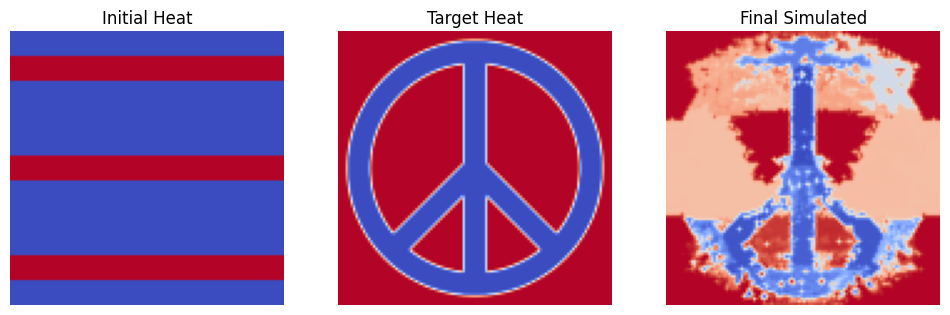

In [18]:
main()

In [13]:
image_folder = 'output2'
image_files = sorted([
    os.path.join(image_folder, fname)
    for fname in os.listdir(image_folder)
    if fname.endswith('.png')
])

gif_filename = 'advection_diffusion_heat.gif'
with imageio.get_writer(gif_filename, mode='I', duration=0.05) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"Saved animation to {gif_filename}")

Saved animation to advection_diffusion_heat.gif


/var/folders/vw/2yrdy95s5q71dwfz0mwsvmrm0000gn/T/ipykernel_15611/3604463022.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
